# Dogs vs Cat Redux

## In this tutorial, you will learn how generate and submit predictions to a Kaggle competiton

[Dogs vs. Cats Redux: Kernels Edition](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)
    
    

To start you will need to download and unzip the competition data from Kaggle and ensure your directory structure looks like this
```
utils/
    vgg16.py
    utils.py
lesson1/
    redux.ipynb
    data/
        redux/
            train/
                cat.437.jpg
                dog.9924.jpg
                cat.1029.jpg
                dog.4374.jpg
            test/
                231.jpg
                325.jpg
                1235.jpg
                9923.jpg
```

You can download the data files from the competition page [here](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data) or you can download them from the command line using the [Kaggle CLI](https://github.com/floydwch/kaggle-cli).

You should launch your notebook inside the lesson1 directory
```
cd lesson1
jupyter notebook
```

In [6]:
#Verify we are in the lesson1 directory
%pwd

'C:\\Python\\AI'

In [1]:
#Create references to important directories we will use over and over
import os, sys
from importlib import reload
current_dir = os.getcwd()
LESSON_HOME_DIR = current_dir
DATA_HOME_DIR = current_dir+'/data/dogscats'

In [2]:
%cd $current_dir
#Allow relative imports to directories above lesson1/
sys.path.insert(1, os.path.join(sys.path[0], '..'))

#import modules
from utils import *
import vgg16bn2
reload(vgg16bn2)
from vgg16bn2 import Vgg16

#Instantiate plotting tool
#In Jupyter notebooks, you will need to run this command before doing any plotting
%matplotlib inline

C:\Python\AI


Using TensorFlow backend.


## Action Plan
1. Create Validation and Sample sets
2. Rearrange image files into their respective directories 
3. Finetune and Train model
4. Generate predictions
5. Validate predictions
6. Submit predictions to Kaggle

## Create validation set and sample

In [66]:
#Create directories
%cd $DATA_HOME_DIR
%mkdir valid
%mkdir results
%mkdir -p sample/train
%mkdir -p sample/test
%mkdir -p sample/valid
%mkdir -p sample/results
%mkdir -p test/unknown

/home/ubuntu/workplace/deep_learning_course/lesson1/data/redux


In [67]:
%cd $DATA_HOME_DIR/train

/home/ubuntu/workplace/deep_learning_course/lesson1/data/redux/train


In [68]:
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(2000): os.rename(shuf[i], DATA_HOME_DIR+'/valid/' + shuf[i])

In [69]:
from shutil import copyfile

In [70]:
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(200): copyfile(shuf[i], DATA_HOME_DIR+'/sample/train/' + shuf[i])

In [71]:
%cd $DATA_HOME_DIR/valid

/home/ubuntu/workplace/deep_learning_course/lesson1/data/redux/valid


In [72]:
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(50): copyfile(shuf[i], DATA_HOME_DIR+'/sample/valid/' + shuf[i])

## Rearrange image files into their respective directories

In [73]:
#Divide cat/dog images into separate directories

%cd $DATA_HOME_DIR/sample/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_DIR/sample/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_DIR/valid
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

%cd $DATA_HOME_DIR/train
%mkdir cats
%mkdir dogs
%mv cat.*.jpg cats/
%mv dog.*.jpg dogs/

/home/ubuntu/workplace/deep_learning_course/lesson1/data/redux/sample/train
/home/ubuntu/workplace/deep_learning_course/lesson1/data/redux/sample/valid
/home/ubuntu/workplace/deep_learning_course/lesson1/data/redux/valid
/home/ubuntu/workplace/deep_learning_course/lesson1/data/redux/train


In [74]:
# Create single 'unknown' class for test set
%cd $DATA_HOME_DIR/test
%mv *.jpg unknown/

/home/ubuntu/workplace/deep_learning_course/lesson1/data/redux/test


## Finetuning and Training

In [3]:
%cd $DATA_HOME_DIR

#Set path to sample/ path if desired
path = DATA_HOME_DIR + '/'
#path = DATA_HOME_DIR + '/sample/'
test_path = DATA_HOME_DIR + '/test/' #We use all the test data
results_path = DATA_HOME_DIR + '/results/'
train_path = path + '/train/'
valid_path = path + '/valid/'
model_path = path + '/models/'

C:\Python\AI\data\dogscats


In [4]:
#import Vgg16 helper class
vgg = Vgg16()

In [5]:
#Set constants. You can experiment with no_of_epochs to improve the model
batch_size=20
no_of_epochs=3

In [6]:
#Finetune the model
batches = vgg.get_batches(train_path, 
                          gen=image.ImageDataGenerator(
                                rotation_range=10,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                shear_range=0.1,
                                zoom_range=0.1,
                                horizontal_flip=True), 
                          batch_size=batch_size)
val_batches = vgg.get_batches(valid_path, batch_size=batch_size)  # no data augmentation
vgg.finetune(batches)

#Not sure if we set this for all fits
vgg.model.optimizer.lr = 0.001
coverage = 1

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [8]:
vgg.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 3, 224, 224)       0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 3, 226, 226)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 224, 224)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 64, 226, 226)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 224, 224)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 112, 112)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 64, 114, 114)      0         
__________

In [23]:
vgg.model.load_weights(results_path+'ft_bn_sgd0.001_0.h5')

In [8]:
vgg.model.optimizer.lr = 0.0001
vgg.model.optimizer.momentum = 0.9

In [9]:
#Notice we are passing in the validation dataset to the fit() method
#For each epoch we test our model against the validation set
latest_weights_filename = None
for epoch in range(no_of_epochs):
    print(f"Running epoch: {epoch}")
    vgg.fit(batches, val_batches, nb_epoch=1, coverage=coverage)
    latest_weights_filename = f'ft_bn{vgg.model.optimizer.lr}_cv{coverage}_{epoch}.h5'
    vgg.model.save_weights(results_path+latest_weights_filename)
print(f"Completed {no_of_epochs} fit operations")

Running epoch: 0
Epoch 1/1
1150/1150 [==============================] - 1009s - loss: 0.1995 - acc: 0.9567 - val_loss: 0.0982 - val_acc: 0.9785
Running epoch: 1
Epoch 1/1
   3/1150 [..............................] - ETA: 970s - loss: 0.3583 - acc: 0.9667

KeyboardInterrupt: 

In [8]:
# Train Ensemble
# TODO: proper ensemble creation
total_models = 5
for i_mod in range(total_models):
    latest_weights_filename = None
    for epoch in range(no_of_epochs):
        print(f"Running epoch: {epoch}")
        vgg.fit(batches, val_batches, nb_epoch=1, coverage=coverage)
        latest_weights_filename = f'ft_bn_ens{i_mod}_{vgg.model.optimizer.lr}_cv{coverage}_{epoch}.h5'
        vgg.model.save_weights(results_path+latest_weights_filename)
    print(f"Completed {no_of_epochs} fit operations")

Running epoch: 0
Epoch 1/1
1438/1437 [==============================] - 971s - loss: 0.4440 - acc: 0.9438 - val_loss: 0.1709 - val_acc: 0.9720
Running epoch: 1
Epoch 1/1
1438/1437 [==============================] - 964s - loss: 0.2756 - acc: 0.9487 - val_loss: 0.2035 - val_acc: 0.9640
Running epoch: 2
Epoch 1/1
1438/1437 [==============================] - 964s - loss: 0.2294 - acc: 0.9539 - val_loss: 0.1345 - val_acc: 0.9735
Completed 3 fit operations
Running epoch: 0
Epoch 1/1
1438/1437 [==============================] - 963s - loss: 0.2013 - acc: 0.9553 - val_loss: 0.0995 - val_acc: 0.9755
Running epoch: 1
Epoch 1/1
1438/1437 [==============================] - 963s - loss: 0.1800 - acc: 0.9574 - val_loss: 0.0992 - val_acc: 0.9765
Running epoch: 2
Epoch 1/1
1438/1437 [==============================] - 963s - loss: 0.1759 - acc: 0.9575 - val_loss: 0.0945 - val_acc: 0.9730
Completed 3 fit operations
Running epoch: 0
Epoch 1/1
1438/1437 [==============================] - 965s - loss: 0.1

KeyboardInterrupt: 

In [20]:
vgg.model.save_weights(results_path+'ft2.h5')

In [8]:
vgg.model.save_weights(results_path+'ft_bn_sgd0.001_0.h5')

In [10]:
def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())
val_data = load_array(model_path+'valid_data.bc')
val_labels = onehot(val_batches.classes)

In [11]:
vgg.model.evaluate(val_data, val_labels, batch_size=batch_size)

2000/2000 [==============================] - 74s    


[0.094313204143275015, 0.97999999582767483]

Let's use our new model to make predictions on the test dataset

## Validate Predictions

Keras' *fit()* function conveniently shows us the value of the loss function, and the accuracy, after every epoch ("*epoch*" refers to one full run through all training examples). The most important metrics for us to look at are for the validation set, since we want to check for over-fitting. 

- **Tip**: with our first model we should try to overfit before we start worrying about how to reduce over-fitting - there's no point even thinking about regularization, data augmentation, etc if you're still under-fitting! (We'll be looking at these techniques shortly).

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (ie those with highest probability that are correct)
4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
5. The most uncertain labels (ie those with probability closest to 0.5).

Let's see what we can learn from these examples. (In general, this is a particularly useful technique for debugging problems in the model. However, since this model is so simple, there may not be too much to learn at this stage.)

Calculate predictions on validation set, so we can find correct and incorrect examples:

In [64]:
val_batches_eval, probs = vgg.test(valid_path, batch_size = batch_size)

Found 2000 images belonging to 2 classes.
125/125 [==============================] - 67s    


Found 2000 images belonging to 2 classes.
125/125 [==============================] - 71s    
[[990  10]
 [ 34 966]]
     fun: 0.10572388834506273
 message: 'Solution found.'
    nfev: 13
  status: 0
 success: True
       x: 0.021987860612221133 

Found 2000 images belonging to 2 classes.
125/125 [==============================] - 74s    
[[975  25]
 [ 29 971]]
     fun: 0.12415397439338267
 message: 'Solution found.'
    nfev: 11
  status: 0
 success: True
       x: 0.026997085805887285 

Found 2000 images belonging to 2 classes.
125/125 [==============================] - 75s    
[[987  13]
 [ 40 960]]
     fun: 0.12235690031200647
 message: 'Solution found.'
    nfev: 14
  status: 0
 success: True
       x: 0.026486115176705346 

Found 2000 images belonging to 2 classes.
125/125 [==============================] - 74s    
[[979  21]
 [ 22 978]]
     fun: 0.10382078502234071
 message: 'Solution found.'
    nfev: 14
  status: 0
 success: True
       x: 0.021496563249738698 

Found 2000 i

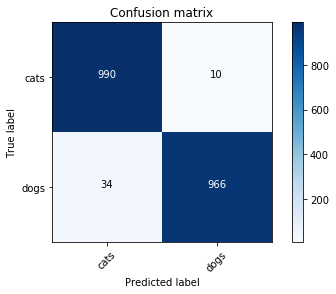

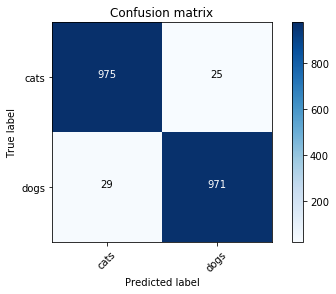

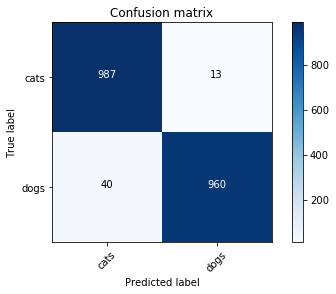

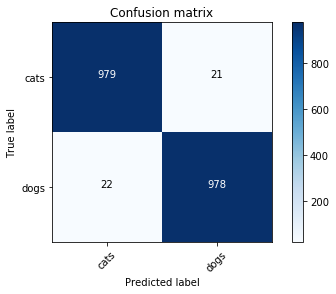

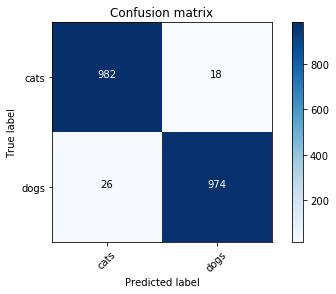

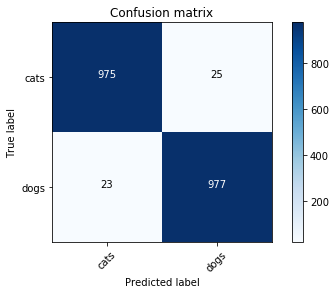

In [14]:
# Ensemble
model_files = ['ft_bn_ens1_0.001_cv1_0.h5',
               'ft_bn_ens1_0.001_cv1_1.h5',
               'ft_bn_ens1_0.001_cv1_2.h5',
               'ft_bn_ens2_0.001_cv1_0.h5',
               'ft_bn_ens2_0.001_cv1_1.h5',
               'ft_bn_ens2_0.001_cv1_2.h5']

for model_file in model_files:
    vgg.model.load_weights(results_path+model_file)
    
    val_batches_eval, probs = vgg.test(valid_path, batch_size = batch_size)
    filenames = val_batches_eval.filenames
    
    save_array(results_path + f'test_preds_{model_file}.dat', probs)
    save_array(results_path + f'filenames_{model_file}.dat', filenames)
    
    expected_labels = val_batches_eval.classes #0 or 1

    #Round our predictions to 0/1 to generate labels
    our_predictions = probs[:,0]
    our_labels = np.round(1-our_predictions)
    
    from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, precision_recall_curve
    cm = confusion_matrix(expected_labels, our_labels)
    plot_confusion_matrix(cm, val_batches_eval.class_indices)
    
    import scipy
    from sklearn.metrics import log_loss
    min_logloss = scipy.optimize.minimize_scalar(lambda x: log_loss(expected_labels, our_labels, eps=x), bounds=(1e-10, 0.1), method='bounded')
    print(min_logloss, '\n')

In [12]:
val_batches_final, probs = vgg.test(valid_path, batch_size = batch_size)

Found 2000 images belonging to 2 classes.
100/100 [==============================] - 72s    


In [28]:
filenames = val_batches_final.filenames
expected_labels = val_batches_final.classes #0 or 1

#Round our predictions to 0/1 to generate labels
our_predictions = probs[:,0]
our_is_dog = probs[:,1]
our_labels = np.round(1-our_predictions)

In [14]:
from keras.preprocessing import image

#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots_idx(idx, titles=None):
    plots([image.load_img(valid_path + filenames[i]) for i in idx], titles=titles)
    
#Number of images to view for each visualization task
n_view = 4

Found 1960 correct labels


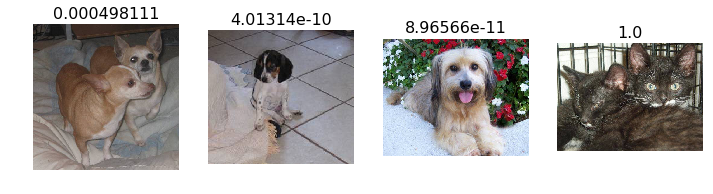

In [15]:
#1. A few correct labels at random
correct = np.where(our_labels==expected_labels)[0]
print(f"Found {len(correct)} correct labels")
idx = permutation(correct)[:n_view]
plots_idx(idx, our_predictions[idx])

Found 35 incorrect labels


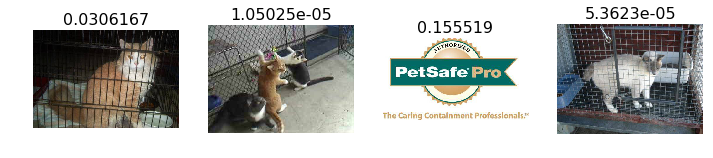

In [15]:
#2. A few incorrect labels at random
incorrect = np.where(our_labels!=expected_labels)[0]
print(f"Found {len(incorrect)} incorrect labels")
idx = permutation(incorrect)[:n_view]
plots_idx(idx, our_predictions[idx])

Found 980 confident correct cats labels


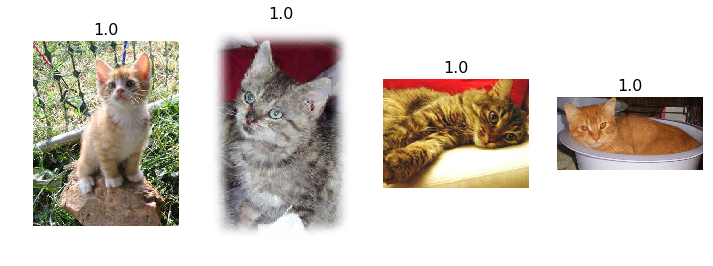

In [33]:
#3a. The images we most confident were cats, and are actually cats
correct_cats = np.where((our_labels==0) & (our_labels==expected_labels))[0]
print(f"Found {len(correct_cats)} confident correct cats labels")
most_correct_cats = np.argsort(our_predictions[correct_cats])[::-1][:n_view]
plots_idx(correct_cats[most_correct_cats], our_predictions[correct_cats][most_correct_cats])

Found 984 confident correct dogs labels


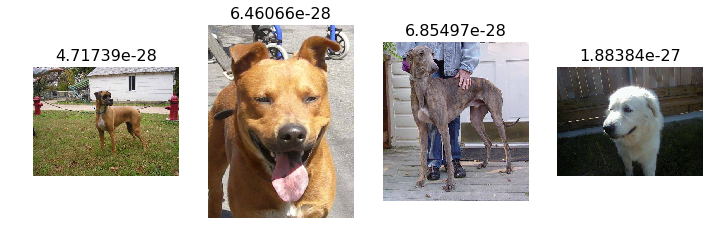

In [34]:
#3b. The images we most confident were dogs, and are actually dogs
correct_dogs = np.where((our_labels==1) & (our_labels==expected_labels))[0]
print(f"Found {len(correct_dogs)} confident correct dogs labels")
most_correct_dogs = np.argsort(our_predictions[correct_dogs])[:n_view]
plots_idx(correct_dogs[most_correct_dogs], our_predictions[correct_dogs][most_correct_dogs])

Found 16 incorrect cats


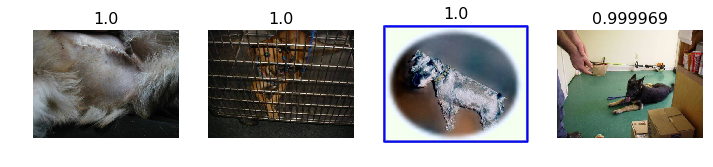

In [35]:
#4a. The images we were most confident were cats, but are actually dogs
incorrect_cats = np.where((our_labels==0) & (our_labels!=expected_labels))[0]
print(f"Found {len(incorrect_cats)} incorrect cats")
if len(incorrect_cats):
    most_incorrect_cats = np.argsort(our_predictions[incorrect_cats])[::-1][:n_view]
    plots_idx(incorrect_cats[most_incorrect_cats], our_predictions[incorrect_cats][most_incorrect_cats])

Found 20 incorrect dogs


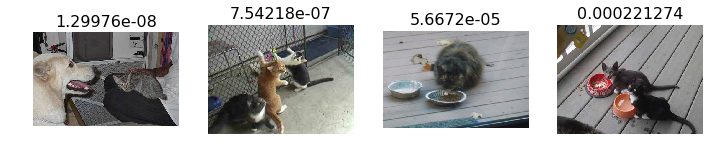

In [36]:
#4b. The images we were most confident were dogs, but are actually cats
incorrect_dogs = np.where((our_labels==1) & (our_labels!=expected_labels))[0]
print(f"Found {len(incorrect_dogs)} incorrect dogs")
if len(incorrect_dogs):
    most_incorrect_dogs = np.argsort(our_predictions[incorrect_dogs])[:n_view]
    plots_idx(incorrect_dogs[most_incorrect_dogs], our_predictions[incorrect_dogs][most_incorrect_dogs])

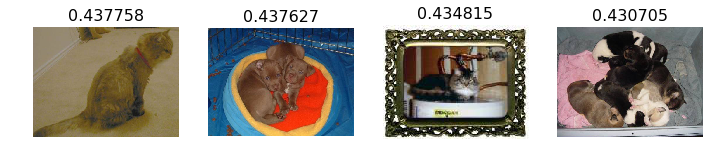

In [37]:
#5. The most uncertain labels (ie those with probability closest to 0.5).
most_uncertain = np.argsort(np.abs(our_predictions-0.5))
plots_idx(most_uncertain[:n_view], our_predictions[most_uncertain])

Perhaps the most common way to analyze the result of a classification model is to use a [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/). Scikit-learn has a convenient function we can use for this purpose:

In [16]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, precision_recall_curve
cm = confusion_matrix(expected_labels, our_labels)

We can just print out the confusion matrix, or we can show a graphical view (which is mainly useful for dependents with a larger number of categories).

[[988  12]
 [ 28 972]]


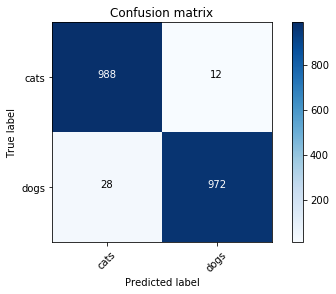

In [17]:
plot_confusion_matrix(cm, val_batches_final.class_indices)

Precision/Recall/Accuracy stats

In [18]:
print('precision:', precision_score(expected_labels, our_labels)) 
print('recall:', recall_score(expected_labels, our_labels)) 
print('accuracy:', accuracy_score(expected_labels, our_labels)) 

precision: 0.987804878049
recall: 0.972
accuracy: 0.98


## Generate Predictions

Let's use our new model to make predictions on the test dataset

In [ ]:
batches, preds = vgg.test(test_path, batch_size = batch_size)

In [36]:
#For every image, vgg.test() generates two probabilities 
#based on how we've ordered the cats/dogs directories.
#It looks like column one is cats and column two is dogs
print(preds[:5])

filenames = batches.filenames
print(filenames[:5])

[[  1.7766e-09   1.0000e+00]
 [  1.0000e+00   5.1332e-09]
 [  1.0000e+00   6.3773e-07]
 [  6.7315e-08   1.0000e+00]
 [  7.7023e-05   9.9992e-01]]
['unknown\\1.jpg', 'unknown\\10.jpg', 'unknown\\100.jpg', 'unknown\\1000.jpg', 'unknown\\10000.jpg']


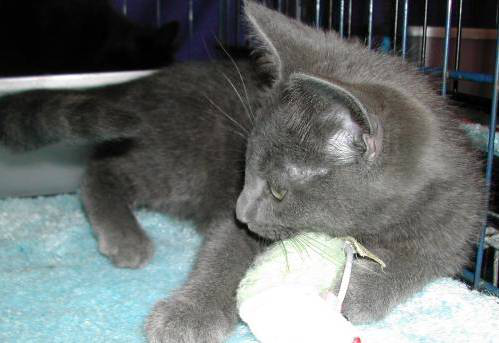

In [37]:
#You can verify the column ordering by viewing some images
from PIL import Image
Image.open(test_path + filenames[2])

In [38]:
#Save our test results arrays so we can use them again later
save_array(results_path + 'test_preds.dat', preds)
save_array(results_path + 'filenames.dat', filenames)

## Submit Predictions to Kaggle!

Here's the format Kaggle requires for new submissions:
```
imageId,isDog
1242, .3984
3947, .1000
4539, .9082
2345, .0000
```

Kaggle wants the imageId followed by the probability of the image being a dog. Kaggle uses a metric called [Log Loss](http://wiki.fast.ai/index.php/Log_Loss) to evaluate your submission.

In [32]:
#Load our test predictions from file
preds = load_array(results_path + 'test_preds.dat')
filenames = load_array(results_path + 'filenames.dat')

In [39]:
#Grab the dog prediction column
isdog = preds[:,1]
print("Raw Predictions: " + str(isdog[:5]))
print("Mid Predictions: " + str(isdog[(isdog < .6) & (isdog > .4)]))
print("Edge Predictions: " + str(isdog[(isdog == 1) | (isdog == 0)]))

Raw Predictions: [  1.0000e+00   5.1332e-09   6.3773e-07   1.0000e+00   9.9992e-01]
Mid Predictions: [ 0.4637  0.4795  0.4712  0.4072  0.4003  0.5562  0.4429  0.4172  0.4734  0.588   0.5074  0.5802
  0.4853  0.4137  0.5094  0.4571  0.42    0.5176  0.5036  0.5743  0.5105  0.4009  0.5469  0.4084
  0.4631  0.5029  0.5923  0.4285  0.4632  0.4822  0.4756  0.4196  0.4684  0.514   0.4171  0.5004
  0.5479  0.4087  0.4589  0.5689  0.4277  0.523   0.5278]
Edge Predictions: [ 1.  1.  1. ...,  1.  1.  1.]


[Log Loss](http://wiki.fast.ai/index.php/Log_Loss) doesn't support probability values of 0 or 1--they are undefined (and we have many). Fortunately, Kaggle helps us by offsetting our 0s and 1s by a very small value. So if we upload our submission now we will have lots of .99999999 and .000000001 values. This seems good, right?

Not so. There is an additional twist due to how log loss is calculated--log loss rewards predictions that are confident and correct (p=.9999,label=1), but it punishes predictions that are confident and wrong far more (p=.0001,label=1). See visualization below.

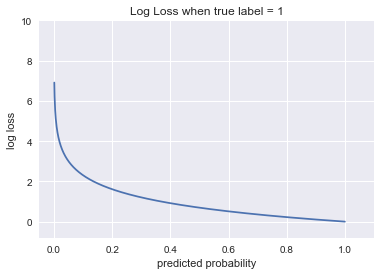

In [40]:
#Visualize Log Loss when True value = 1
#y-axis is log loss, x-axis is probabilty that label = 1
#As you can see Log Loss increases rapidly as we approach 0
#But increases slowly as our predicted probability gets closer to 1
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import log_loss
import seaborn as sns
sns.set()

x = [i*.001 for i in range(1,1000)]
y = [log_loss([0], [[i*.001,1-(i*.001)]], eps=1e-15, labels=[0, 1]) for i in range(1,1000,1)]

plt.plot(x, y)
plt.axis([-.05, 1.1, -.8, 10])
plt.title("Log Loss when true label = 1")
plt.xlabel("predicted probability")
plt.ylabel("log loss")

plt.show()

In [41]:
import scipy
min_logloss = scipy.optimize.minimize_scalar(lambda x: log_loss(expected_labels, our_is_dog, eps=x), bounds=(1e-10, 0.1), method='bounded')

     fun: 0.071108161114621912
 message: 'Solution found.'
    nfev: 15
  status: 0
 success: True
       x: 0.0073628710664220432

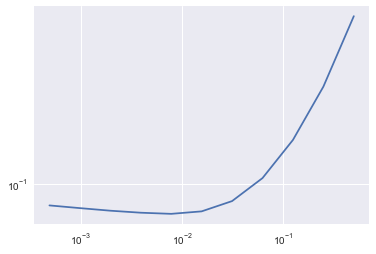

In [42]:
eps_x = [0.5**i for i in range(1,12)]
eps_y = [log_loss(expected_labels, our_is_dog, eps=eps) for eps in eps_x]
plt.loglog(eps_x, eps_y)
min_logloss

In [43]:
#So to play it safe, we use a sneaky trick to round down our edge predictions
#Swap all ones with .95 and all zeros with .05
eps = min_logloss.x
isdog = isdog.clip(min=eps, max=1-eps)

In [44]:
#Extract imageIds from the filenames in our test/unknown directory 
filenames = batches.filenames
ids = np.array([int(f[8:f.find('.')]) for f in filenames])

Here we join the two columns into an array of [imageId, isDog]

In [45]:
subm = np.stack([ids,isdog], axis=1)
subm[:5]

array([[  1.0000e+00,   9.9264e-01],
       [  1.0000e+01,   7.3629e-03],
       [  1.0000e+02,   7.3629e-03],
       [  1.0000e+03,   9.9264e-01],
       [  1.0000e+04,   9.9264e-01]])

In [47]:
%cd $DATA_HOME_DIR
submission_file_name = 'submission5.csv'
np.savetxt(submission_file_name, subm, fmt='%d,%.5f', header='id,label', comments='')

C:\Python\AI\data\dogscats


You can download this file and submit on the Kaggle website or use the Kaggle command line tool's "submit" method.

In [48]:
pd.read_csv(submission_file_name, index_col='id')

,label
id,
1,0.99264
10,0.00736
100,0.00736
1000,0.99264
10000,0.99264
10001,0.00736
10002,0.00736
10003,0.99264
10004,0.99264


In [49]:
submission_message = f"VGG16 finetuned with batch normalization -- ft_bn0.0001_cv1_0.h5 logloss={min_logloss.fun:.5} eps={eps:.5}"
!kg submit $submission_file_name -m "$submission_message"

0.08874
